In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/room0' # 30000

FEATURE_GAUSSIAN_ITERATION = 30000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = False

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/room0\cfg_args
Config file found: ./output/room0\cfg_args
Loading trained model at iteration 30000, 30000
Allow Camera Principle Point Shift: False
Reading camera 9/80

C:\Users\EROS\AppData\Local\Temp\ipykernel_18444\4090271028.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
C:\Us

Reading camera 80/80
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

17.712616 ?


In [5]:
all_scales.max()

tensor(17.7126, grad_fn=<MaxBackward1>)

In [6]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [7]:
upper_bound_scale

17.712615966796875

In [8]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [9]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 80 views in the dataset.
17.712615966796875


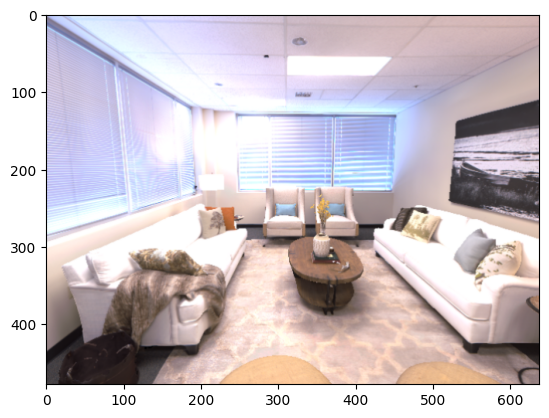

In [10]:
ref_img_camera_id = 17
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

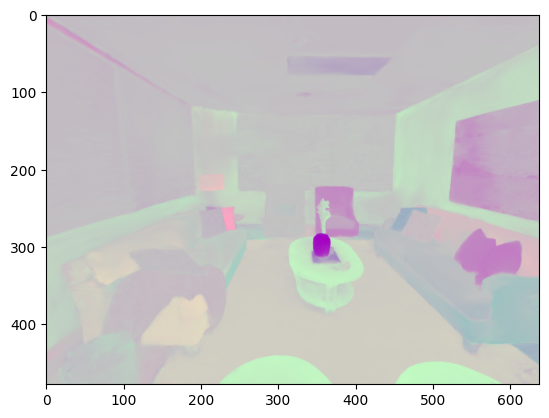

In [11]:
with torch.no_grad():
    # If the q_trans is normal
    scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    #scale = torch.tensor([0]).cuda()
    #scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    data = scale_conditioned_feature[:,:,:3].detach().cpu().numpy()
    normalized_data = (data - data.min()) / (data.max() - data.min())
    plt.imshow(normalized_data)
    

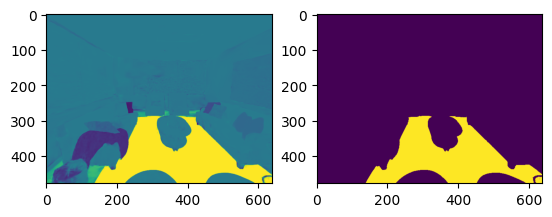

In [12]:
query_index = (400, 250)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

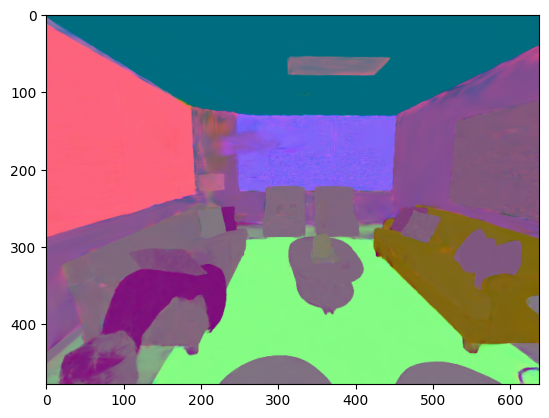

In [13]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)


t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
plt.imshow(t)

# Cluster in 2D

In [14]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [15]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

C:\Users\EROS\anaconda3\envs\gaussian_splatting\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\EROS\anaconda3\envs\gaussian_splatting\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53]


In [16]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

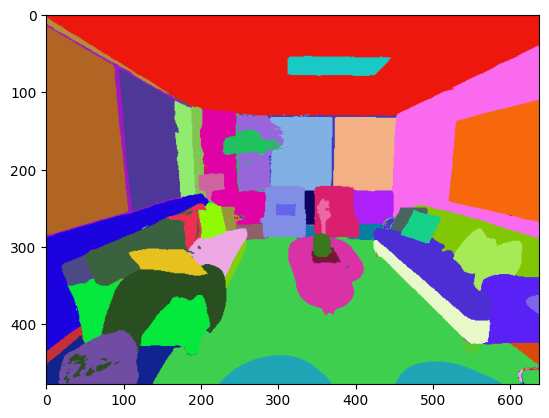

In [17]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [37]:
point_features = feature_gaussians.get_point_features
print(point_features.shape)
scale_conditioned_point_features = point_features * gates.unsqueeze(0)


torch.Size([576334, 32])


In [19]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.5] = 0

In [20]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[5], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

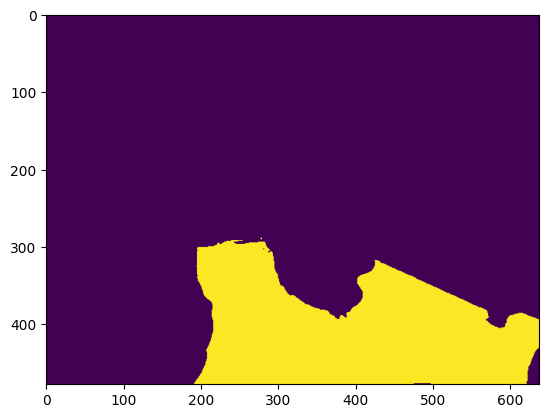

In [21]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [22]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.75)

In [23]:
# save the segmentation
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.75, f'./segmentation_res/{name}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019331396..2.5632324].


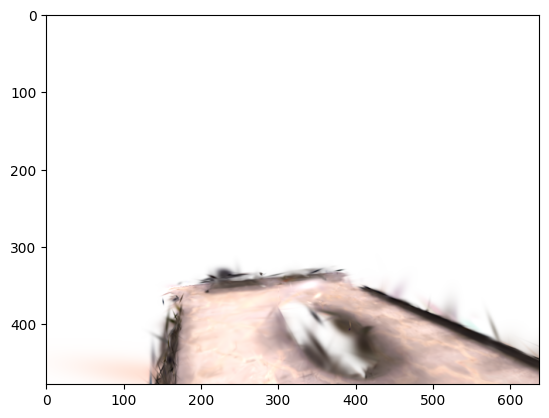

In [24]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[0], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

In [25]:
scene_gaussians.roll_back()

# Cluster in 3D

In [26]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

11465


In [27]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

C:\Users\EROS\anaconda3\envs\gaussian_splatting\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\EROS\anaconda3\envs\gaussian_splatting\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]


In [28]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [29]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [30]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [31]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

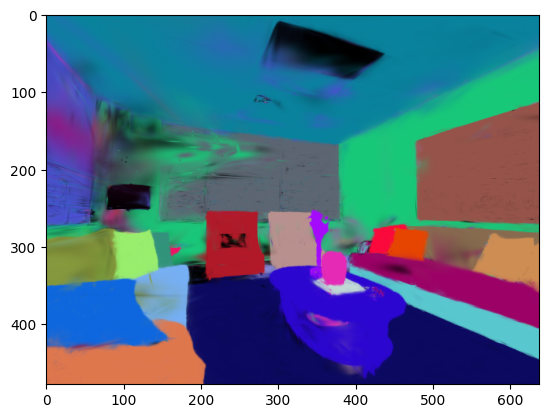

In [32]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

# Language-driven Segmentation

In [33]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

5834


In [34]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        scales.append(view.mask_scales.cuda().unsqueeze(-1))

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()

In [35]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
flattened_clip_features = torch.cat(clip_features, dim = 0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

TypeError: expected Tensor as element 0 in argument 0, but got NoneType

In [ ]:

with torch.no_grad():
    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1) + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0) - torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) + 1e-6))

In [ ]:
# Construct vote graph

from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)

In [ ]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()
1

In [ ]:
# Convert input text prompts to scores for multi-view masks

scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "old camera")
scores = scores.squeeze()

In [ ]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    cluster_scores[cluster_idx+1] = scores[cluster_labels == cluster_idx].mean()

In [ ]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

In [ ]:
good_clusters = torch.where(cluster_scores > 0.45)[0]
good_cluster_scores = cluster_scores[good_clusters]
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

clip_query_features = []
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

In [ ]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


In [ ]:
index = 0
similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
good_cluster_scores

In [ ]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.85)

In [ ]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[0], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
